<a href="https://www.kaggle.com/code/ssevinc/gradient-boosting-from-scratch-vs-scikit-learn?scriptVersionId=235320484" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Gradient Boosting from Scratch vs. Scikit-Learn
-

This notebook focuses on predicting individual medical costs using regression models ‚Äî specifically, gradient boosting. The key highlight of this project is the development of a gradient boosting regressor from scratch, followed by a performance comparison with Scikit-learn's GradientBoostingRegressor.

The goal is to not only build an accurate predictive model, but also gain intuitive understanding of how gradient boosting works under the hood, through hands-on implementation.

***üîç What's in the Notebook?***

**1. Data Preparation**
Load and explore the insurance dataset
Perform basic preprocessing (one-hot encoding for categorical variables)
Visualize relationships between features (e.g., bmi, smoker, age) and the target charges

**2. Train-Test Split**
Divide the data into training and testing sets (70/30 split)

**3. Gradient Boosting From Scratch**
Start with a base prediction (the mean of charges)
Define a custom decision tree splitting rule using domain knowledge (age, bmi, smoker, etc.)


**4. Visualizing Model Performance**
Plot training and test MAE vs. boosting rounds to detect overfitting or underfitting
Visualize predicted vs. actual charges on a scatter plot
Calculate performance metrics:
MAE (Mean Absolute Error)
R¬≤ Score

**5. Sklearn GradientBoostingRegressor**
Train on the same data
Predict and evaluate using the same metrics
Visualize the predictions for side-by-side comparison

**6. Results & Comparison**
Compare the hand-built model to Scikit-learn's model
Analyze MAE and R¬≤

**Why This Notebook Matters**

You'll see how predictions improve step-by-step.

You‚Äôll understand the role of residuals in building the next correction.

And you‚Äôll get a visual, intuitive grasp of how boosting ‚Äúlearns‚Äù.

If you enjoy this notebook or find it useful, feel free to ‚≠êÔ∏è upvote and fork it!
-



Step 1: Import Libraries
-
**We begin by importing the necessary libraries for data manipulation, visualization, and model building. We'll also bring in Scikit-learn tools later for benchmarking.**

In [30]:

import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import warnings
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/insurance/insurance.csv


Step 2: Load the Dataset
-
**We load the insurance dataset, which contains demographic information and medical charges. This will be the foundation for our predictive modeling. And display the first few rows to get a feel for the data structure, feature types, and potential issues (like categorical variables).**

In [3]:
data= pd.read_csv("/kaggle/input/insurance/insurance.csv")
data.head(10)

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
5   31  female  25.740         0     no  southeast   3756.62160
6   46  female  33.440         1     no  southeast   8240.58960
7   37  female  27.740         3     no  northwest   7281.50560
8   37    male  29.830         2     no  northeast   6406.41070
9   60  female  25.840         0     no  northwest  28923.13692

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Step 4: Drop 'region' for Simplicity
-

**To keep our model interpretable and lightweight for manual boosting, we drop the `region` column in this version. Feel free to keep it for a more complex model later.**

In [5]:
data = data.drop(['region'],axis='columns')

Step 5: One-Hot Encode Categorical Variables
-

**Since models can't directly work with text values like 'sex' or 'smoker', we convert them into numerical columns using one-hot encoding. We drop the first category to avoid redundancy.**


In [6]:

df_encoded = pd.get_dummies(data, columns=['smoker','sex'],drop_first=True)

In [7]:
print(df_encoded.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1338 non-null   int64  
 1   bmi         1338 non-null   float64
 2   children    1338 non-null   int64  
 3   charges     1338 non-null   float64
 4   smoker_yes  1338 non-null   bool   
 5   sex_male    1338 non-null   bool   
dtypes: bool(2), float64(2), int64(2)
memory usage: 44.6 KB
None


Step 6: Visual Exploration (Optional)
-
**This step lets us visually inspect relationships between features and the target variable (`charges`). For example, you‚Äôll notice smokers generally have much higher charges.**

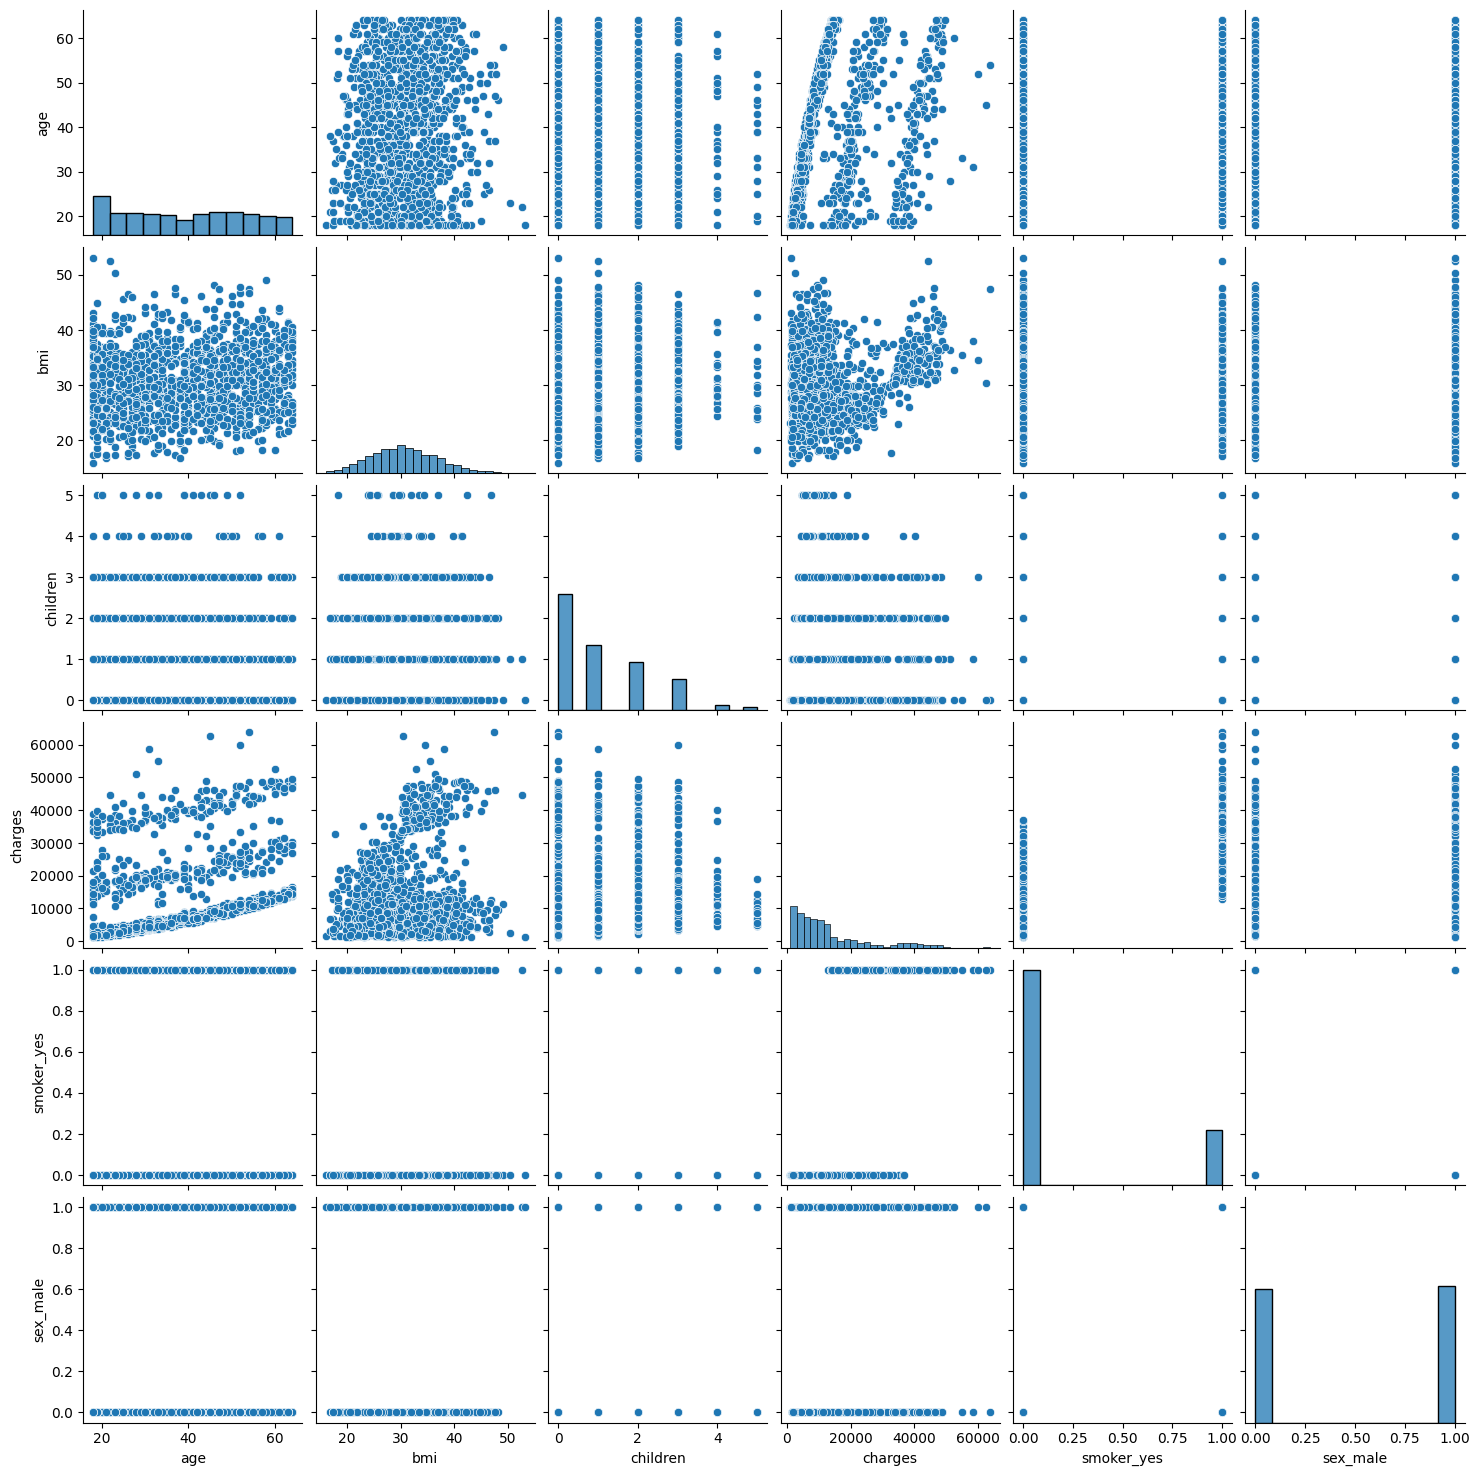

In [32]:
warnings.filterwarnings("ignore")
sns.pairplot(df_encoded)


Step 7: Train-Test Split
-
**We divide the dataset into training and testing sets. This allows us to evaluate our model‚Äôs ability to generalize to unseen data.**

In [10]:
train_data,test_data = train_test_split(
    df_encoded,test_size=0.3, random_state=42
)

Step 8: Set Base Prediction
-
**To start our boosting model, we first predict the same value for everyone ‚Äî the mean of training `charges`. This becomes the starting point for improving our predictions via residual corrections.**


In [11]:
base = np.mean(train_data['charges'])
print(base)

13379.157306773504


Step 9: Calculate Residuals
-

**Now based on this "prediction" we will calculate the residuals for each data point.**

**residual = (observed value-predicted value)**


In [12]:
residuals = train_data['charges'] - base
print(residuals)

332        49.878093
355     11223.891063
138     13943.576553
381     28924.534843
292     28733.078293
            ...     
1095    -8817.968807
1130    -4796.855007
1294    -1448.032057
860     32734.353693
1126    -3164.521307
Name: charges, Length: 936, dtype: float64


Step 10: Store Residuals and Predictions
-

**We store the base prediction and residuals in new columns so we can update them iteratively during boosting.**

In [13]:
train_data['Residuals'] = residuals
train_data['prediction'] = base
train_data.head(10)

age     bmi  children      charges  smoker_yes  sex_male     Residuals  \
332    61  31.160         0  13429.03540       False     False     49.878093   
355    46  27.600         0  24603.04837       False      True  11223.891063   
138    54  31.900         3  27322.73386       False     False  13943.576553   
381    55  30.685         0  42303.69215        True      True  28924.534843   
292    25  45.540         2  42112.23560        True      True  28733.078293   
1090   47  36.190         0  41676.08110        True      True  28296.923793   
1075   32  29.590         1   4562.84210       False     False  -8816.315207   
141    26  32.490         1   3490.54910       False      True  -9888.608207   
676    55  40.810         3  12485.80090       False     False   -893.356407   
626    36  28.880         3   6748.59120       False      True  -6630.566107   

        prediction  
332   13379.157307  
355   13379.157307  
138   13379.157307  
381   13379.157307  
292   13379.157307  
1090  13379.157307  
1075  13379.157307  
141   13379.157307  
676   13379.157307  
626   13379.157307

Step 11: Define a Custom Tree-Splitting Rule
-
**Instead of using Scikit-learn‚Äôs decision trees, we define a manual tree that splits the data based on rules like BMI, smoking status, children and age. This forms the foundation of our model‚Äôs learning logic.**

In [14]:
def tree(person):
    if person['smoker_yes']:
        if person['bmi'] >= 30:
            return 'leaf1'
        else:
            return 'leaf2'
    else:
        if person['sex_male']:
            if person['age'] >= 40:
                return 'leaf3'
            else:
                return 'leaf4'
        else:
            if person['children'] >= 3:
                return 'leaf5'
            else:
                return 'leaf6'


Step 12: Set Boosting Parameters
-
**We define the learning rate (how much we correct each round), number of boosting rounds, and a place to store the corrections for each leaf group.**

In [15]:
learning_rate = 0.1
num_rounds = 100
leaf_corrections = {'leaf1': [], 'leaf2': [], 'leaf3': [], 'leaf4': [],'leaf5':[], 'leaf6':[]}

train_data = train_data.copy()
train_data['prediction'] = base
train_data['Residuals'] = train_data['charges'] - train_data['prediction']

Step 13: Boosting Loop (Training)
-
**Now we enter the heart of the model ‚Äî a loop that:**
- Groups data by leaf
- Calculates the mean residual per leaf
- Applies a scaled correction to each group
- Updates predictions and residuals
  
**We also store the training MAE at each round to track learning progress.**

In [16]:
mae_per_round = []

for _ in range(num_rounds):
    step_corrections = {}

    for leaf in leaf_corrections:
        group = train_data[train_data.apply(tree, axis=1) == leaf]
        if not group.empty:
            mean_residual = group['Residuals'].mean()
            correction = learning_rate * mean_residual
        else:
            correction = 0
        step_corrections[leaf] = correction
        leaf_corrections[leaf].append(correction)


    for idx, row in train_data.iterrows():
        leaf = tree(row)
        train_data.at[idx, 'prediction'] += step_corrections[leaf]

    train_data['Residuals'] = train_data['charges'] - train_data['prediction']
    mae = mean_absolute_error(train_data['charges'], train_data['prediction'])
    mae_per_round.append(mae)
    print(f"Round {_ + 1} MAE: {mae:.2f}")




Round 1 MAE: 8451.07
Round 2 MAE: 7866.79
Round 3 MAE: 7353.08
Round 4 MAE: 6901.74
Round 5 MAE: 6505.45
Round 6 MAE: 6155.87
Round 7 MAE: 5849.10
Round 8 MAE: 5580.84
Round 9 MAE: 5342.90
Round 10 MAE: 5131.74
Round 11 MAE: 4943.96
Round 12 MAE: 4779.35
Round 13 MAE: 4642.88
Round 14 MAE: 4531.57
Round 15 MAE: 4437.84
Round 16 MAE: 4363.23
Round 17 MAE: 4303.11
Round 18 MAE: 4254.10
Round 19 MAE: 4213.70
Round 20 MAE: 4179.14
Round 21 MAE: 4149.11
Round 22 MAE: 4122.77
Round 23 MAE: 4100.02
Round 24 MAE: 4080.32
Round 25 MAE: 4063.20
Round 26 MAE: 4050.08
Round 27 MAE: 4039.68
Round 28 MAE: 4031.20
Round 29 MAE: 4024.22
Round 30 MAE: 4018.36
Round 31 MAE: 4013.20
Round 32 MAE: 4008.65
Round 33 MAE: 4004.74
Round 34 MAE: 4001.41
Round 35 MAE: 3998.94
Round 36 MAE: 3996.93
Round 37 MAE: 3995.16
Round 38 MAE: 3993.59
Round 39 MAE: 3992.18
Round 40 MAE: 3990.93
Round 41 MAE: 3989.83
Round 42 MAE: 3988.86
Round 43 MAE: 3987.99
Round 44 MAE: 3987.21
Round 45 MAE: 3986.52
Round 46 MAE: 3985.

Step 14: Apply Corrections to Test Data
-
**We apply the same set of corrections from training to the test data, round-by-round, without ever looking at the test targets. This simulates how we‚Äôd use the model on new, unseen data.**

In [17]:
test_data = test_data.copy()
test_data['leaf'] = test_data.apply(tree, axis=1)
test_data['prediction'] = base

test_mae_per_round = []

for i in range(num_rounds):
    for idx, row in test_data.iterrows():
        leaf = row['leaf']
        test_data.at[idx, 'prediction'] += leaf_corrections[leaf][i]

    mae = mean_absolute_error(test_data['charges'], test_data['prediction'])
    test_mae_per_round.append(mae)

    print(f"Round {i+1} Test MAE: {mae:.2f}")


Round 1 Test MAE: 8484.74
Round 2 Test MAE: 7881.90
Round 3 Test MAE: 7355.46
Round 4 Test MAE: 6898.92
Round 5 Test MAE: 6505.91
Round 6 Test MAE: 6160.49
Round 7 Test MAE: 5855.83
Round 8 Test MAE: 5584.58
Round 9 Test MAE: 5342.67
Round 10 Test MAE: 5129.50
Round 11 Test MAE: 4939.87
Round 12 Test MAE: 4773.96
Round 13 Test MAE: 4631.45
Round 14 Test MAE: 4511.54
Round 15 Test MAE: 4407.40
Round 16 Test MAE: 4317.55
Round 17 Test MAE: 4240.26
Round 18 Test MAE: 4175.50
Round 19 Test MAE: 4121.59
Round 20 Test MAE: 4076.97
Round 21 Test MAE: 4042.25
Round 22 Test MAE: 4016.48
Round 23 Test MAE: 3996.02
Round 24 Test MAE: 3979.41
Round 25 Test MAE: 3965.32
Round 26 Test MAE: 3953.05
Round 27 Test MAE: 3942.48
Round 28 Test MAE: 3933.71
Round 29 Test MAE: 3925.84
Round 30 Test MAE: 3918.76
Round 31 Test MAE: 3912.40
Round 32 Test MAE: 3906.71
Round 33 Test MAE: 3901.61
Round 34 Test MAE: 3897.13
Round 35 Test MAE: 3893.10
Round 36 Test MAE: 3889.59
Round 37 Test MAE: 3886.78
Round 38 T

Step 15: Track Best Test Round
-
**We find out at which round our test error was lowest ‚Äî this helps us detect overfitting and choose the best number of boosting rounds.**


In [18]:
best_train_round = np.argmin(mae_per_round) + 1
best_train_mae = mae_per_round[best_train_round - 1]
best_test_round = np.argmin(test_mae_per_round) + 1
best_test_mae = test_mae_per_round[best_test_round - 1]

print(f"\n Best Training MAE: {best_train_mae:.2f} at round {best_train_round}")
print(f"\n Best Test MAE: {best_test_mae:.2f} at round {best_test_round}")



 Best Training MAE: 3980.69 at round 100

 Best Test MAE: 3863.97 at round 100


Step 16: Plot MAE Over Boosting Rounds
-
**Here we visualize how error changes over time. A good model will show training and test error decreasing together, then test error stabilizing or rising (indicating overfitting).**


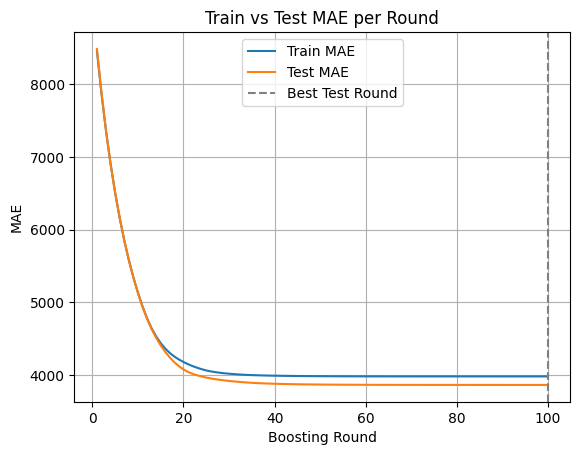

In [19]:
plt.plot(range(1, len(mae_per_round)+1), mae_per_round, label='Train MAE')
plt.plot(range(1, len(test_mae_per_round)+1), test_mae_per_round, label='Test MAE')
plt.axvline(np.argmin(test_mae_per_round)+1, color='gray', linestyle='--', label='Best Test Round')
plt.xlabel("Boosting Round")
plt.ylabel("MAE")
plt.title("Train vs Test MAE per Round")
plt.legend()
plt.grid(True)
plt.show()

Step 17: R¬≤ Score
-

**According to the R¬≤ Score, the model performs with 80%, which is adequete for a simple hand-build algorithm. This gives us a more intuitive understanding of model performance.**

In [20]:

r2 = r2_score(test_data['charges'], test_data['prediction'])
print(f"R¬≤ Score: {np.round(r2*100):.4f}")

R¬≤ Score: 80.0000


Step 18: Train Sklearn Gradient Boosting Regressor
-
**Now we switch to Scikit-learn‚Äôs `GradientBoostingRegressor` to compare performance. This model uses actual decision trees and automated optimization under the hood.**

In [21]:
features = [col for col in df_encoded.columns if col != 'charges']
X_train = train_data[features]
y_train = train_data['charges']
X_test = test_data[features]
y_test = test_data['charges']

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)
gbr_preds = gbr.predict(X_test)

mae = mean_absolute_error(y_test, gbr_preds)
r2 = r2_score(y_test, gbr_preds)
print(f"Gradient Boosting Regressor MAE: {mae:.2f}")
print(f"Gradient Boosting Regressor R¬≤ Score: {r2*100:.4f}")


Gradient Boosting Regressor MAE: 2518.14
Gradient Boosting Regressor R¬≤ Score: 86.9561


Step 19: Evaluate and Visualize Sklearn Model
-

**We calculate the MAE and R¬≤ of the Scikit-learn model and plot its predictions against actual values ‚Äî just like we did for our custom model.**

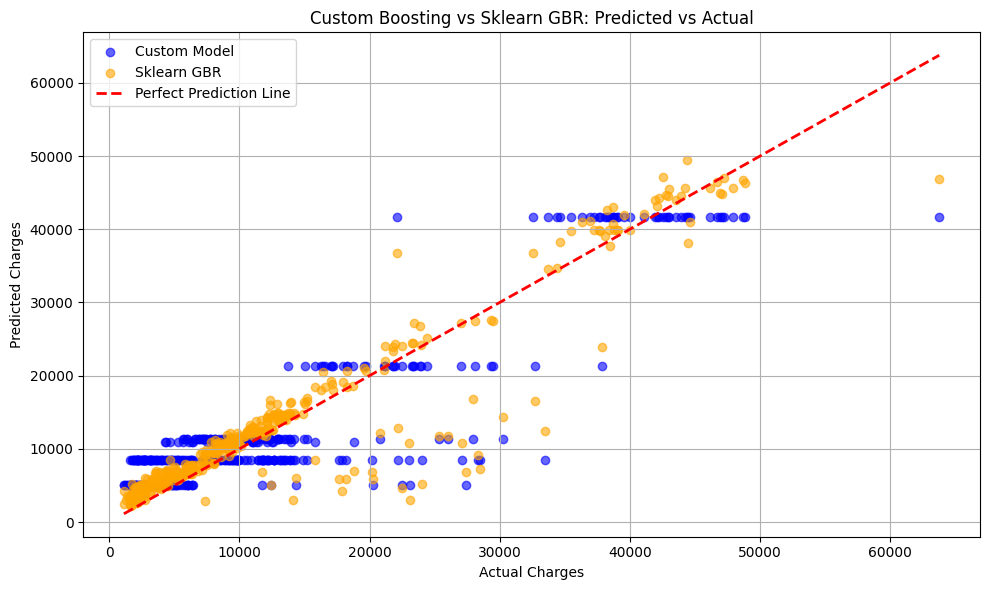

In [22]:
plt.figure(figsize=(10, 6))

# Custom model predictions (already stored in test_data['prediction'])
plt.scatter(y_test, test_data['prediction'], alpha=0.6, label='Custom Model', color='blue')

# Scikit-learn predictions
plt.scatter(y_test, gbr_preds, alpha=0.6, label='Sklearn GBR', color='orange')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction Line')

plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Custom Boosting vs Sklearn GBR: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Final Thoughts
-
**We built a gradient boosting model from scratch and compared it with Scikit-learn‚Äôs implementation. While simple, our custom model performed surprisingly well and gave us valuable insight into how boosting improves predictions round by round.**

**Great for anyone looking to learn boosting from the ground up!**
